In [1]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(zellkonverter)
library(loomR)
library(Seurat)
library(SeuratDisk)
library(data.table)

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
adata_loom <- connect(filename = "/public/LiuTL/Rstudio/skeletal_muscle/moli_v2/data/ICM_FB_Schwann_scvi_adata_diet.loom", mode = "r+",skip.validate = TRUE)

matrix=adata_loom[["matrix"]][,]
matrix=t(matrix)
dim(matrix)

gene = adata_loom$row.attrs$var_names[]
barcode = adata_loom$col.attrs$obs_names[]
meta_data = read.csv('/public/LiuTL/Rstudio/skeletal_muscle/moli_v2/data/ICM_FB_Schwann_scvi_adata_diet_obs.csv',row.names = 1) # 这个直接给个dataframe吧
meta_feature = read.csv('/public/LiuTL/Rstudio/skeletal_muscle/moli_v2/data/ICM_FB_Schwann_scvi_adata_diet_var.csv',row.names = 1)

colnames(matrix)= barcode
row.names(matrix)= gene
x_scvi = adata_loom$col.attrs$X_scVI[,]
x_umap = adata_loom$col.attrs$X_umap[,]

seurat_object_MuSC= CreateSeuratObject(counts = matrix,meta.data = meta_data,
                                       project = 'musc_loom',
                                       min.cells = 0, 
                                       min.features = 0)

seurat_object_MuSC@assays[["RNA"]]@meta.features <- meta_feature
# seurat_object_MuSC@reductions[["scVI"]]@cell.embeddings <- x_scvi

x_scvi = t(x_scvi)
x_umap = t(x_umap)
rownames(x_scvi) = barcode
rownames(x_umap) = barcode
colnames(x_scvi) = c("scVI_1","scVI_2","scVI_3","scVI_4","scVI_5","scVI_6","scVI_7","scVI_8","scVI_9","scVI_10","scVI_11","scVI_12","scVI_13","scVI_14","scVI_15","scVI_16","scVI_17","scVI_18","scVI_19","scVI_20","scVI_21","scVI_22","scVI_23","scVI_24","scVI_25","scVI_26","scVI_27","scVI_28","scVI_29","scVI_30")
colnames(x_umap) = c('umap_1','umap_2')

Warning message in initialize(...):
“Skipping validation step, some fields are not populated”


[1] 33538 20734

Warning message:
“The following arguments are not used: row.names”


In [3]:
sce1 = as.SingleCellExperiment(seurat_object_MuSC)

sce1@int_colData@listData[["reducedDims"]]@listData[["SCVI"]] = x_scvi
sce1@int_colData@listData[["reducedDims"]]@listData[["UMAP"]] = x_umap

In [4]:
milo_obj = Milo(sce1)
milo_obj = buildGraph(milo_obj, k = 35, d = 30,reduced.dim = "SCVI")
milo_obj = makeNhoods(milo_obj, prop = 0.1, k = 35, d=30, refined = TRUE, reduced_dims = "SCVI")
milo_obj = countCells(milo_obj, meta.data = as.data.frame(colData(milo_obj)), sample="SampleID")
head(nhoodCounts(milo_obj))
summary(rowSums(nhoodCounts(milo_obj)))
sample_order = colnames(nhoodCounts(milo_obj))

exp_design <- data.frame(colData(milo_obj))[,c("SampleID","DonorID", "X10X_version", "Sex", "Age_bin")]
exp_design = distinct(exp_design)
rownames(exp_design) = exp_design$SampleID
exp_design = exp_design[sample_order,]
exp_design

milo_obj = calcNhoodDistance(milo_obj, d=30, reduced.dim = "SCVI")
da_results = testNhoods(milo_obj, design = ~ X10X_version+ Sex + Age_bin, design.df = exp_design)
head(da_results)

Constructing kNN graph with k:35

Checking valid object

Checking meta.data validity

Counting cells in neighbourhoods

   [[ suppressing 21 column names ‘mus_SNuc7468112’, ‘mus_SNuc7511880’, ‘5386STDY7600838’ ... ]]



6 x 21 sparse Matrix of class "dgCMatrix"
                                                     
1 23 11 31 21 2 2 4 10 3  6  5  5 6  .  5 5 3 . . 4 3
2  3  3 13 13 . . .  . .  .  2 11 4  6 13 2 2 . . 1 1
3  4  5 41 37 2 1 1  5 .  7  9  5 7 10 10 2 2 . 2 . .
4  .  .  2  1 . . .  . . 33 29  2 . 12  9 8 7 1 . . .
5  .  1 25 22 . . .  . .  1  .  1 1  4  3 1 . . . . .
6 56  6  7 10 4 6 .  1 3  4  .  . 2  3  8 . 5 1 1 6 1

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  35.00   53.00   73.50   84.39  104.00  288.00 

,SampleID,DonorID,X10X_version,Sex,Age_bin
,<chr>,<chr>,<chr>,<chr>,<chr>
mus_SNuc7468112,mus_SNuc7468112,339C,3'v2,F,2Aged
mus_SNuc7511880,mus_SNuc7511880,343B,3'v2,F,2Aged
5386STDY7600838,5386STDY7600838,362C,3'v2,M,2Aged
5386STDY7600839,5386STDY7600839,362C,3'v2,M,2Aged
5386STDY7645353,5386STDY7645353,367C,3'v2,M,2Aged
5386STDY7645354,5386STDY7645354,367C,3'v2,M,2Aged
5386STDY7835292,5386STDY7835292,411C,3'v2,M,1Young
5386STDY7835293,5386STDY7835293,411C,3'v2,M,1Young
5386STDY8047212,5386STDY8047212,464C,3'v2,M,1Young


as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.2168505,10.511701,0.09450537,0.7585280039,0.907886542,1,0.902857439
2,0.8891871,9.803869,1.04240270,0.3072718604,0.616717814,2,0.600263664
3,0.6089433,10.334273,0.76747145,0.3810076911,0.683806923,3,0.668683658
4,-3.9031910,10.226015,18.12523069,0.0000207505,0.001765867,4,0.001105662
5,2.2584106,9.335924,5.79110577,0.0161136818,0.124661302,5,0.109724421
6,0.5328402,10.346587,0.47078901,0.4926299095,0.761379006,6,0.749625163


In [5]:
save.image('./write/human_SKM_v2_FB_moli_v3_r_2.RData')

In [7]:
da_results %>%
  arrange(SpatialFDR) %>%
  head() 

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
667,-5.341055,10.663894,30.28968,3.752533e-08,6.386812e-05,667,3.427617e-05
389,-6.901609,10.095146,28.55264,9.187408e-08,7.818484e-05,389,4.348962e-05
42,-4.651344,10.750058,27.35165,1.707982e-07,9.689950e-05,42,5.352621e-05
866,-5.713980,10.382006,26.77850,2.296842e-07,9.773063e-05,866,5.444732e-05
111,-3.708816,11.059189,23.91771,1.010817e-06,2.984226e-04,111,1.671111e-04
1348,-6.452752,9.854755,23.84074,1.052018e-06,2.984226e-04,1348,1.671111e-04


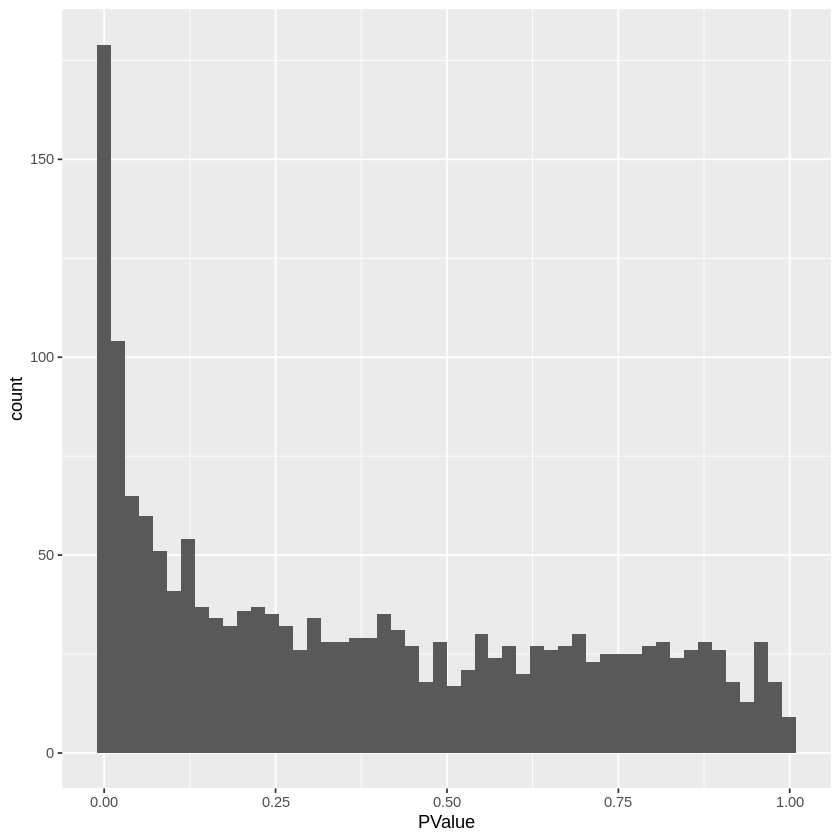

In [8]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

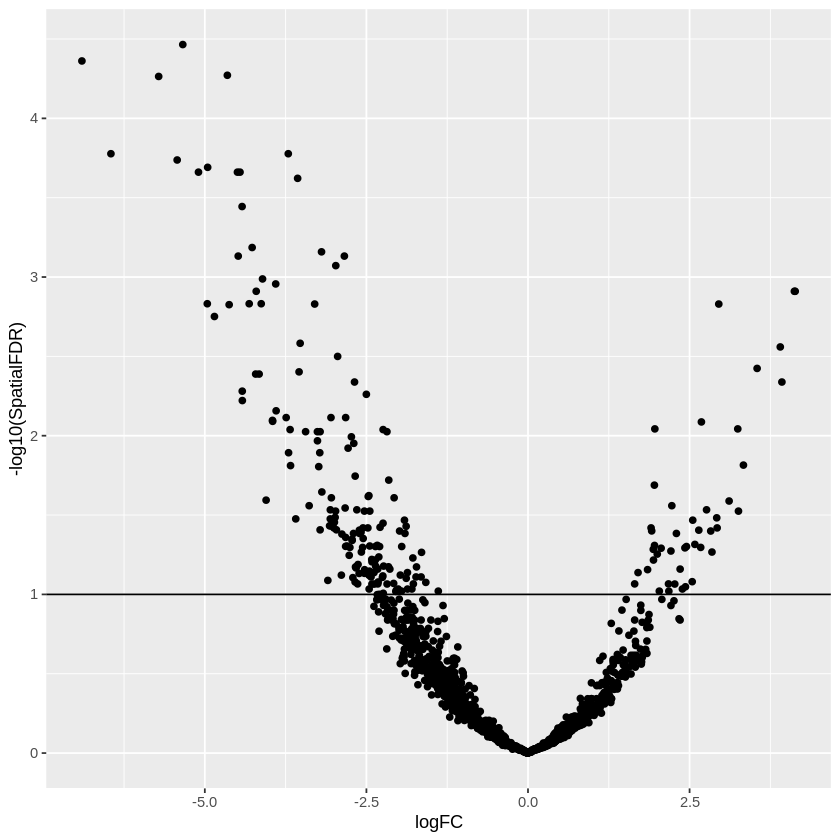

In [9]:
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) +   geom_point() +  geom_hline(yintercept = 1) 

In [10]:
milo_obj = buildNhoodGraph(milo_obj)
colData(milo_obj)

DataFrame with 20734 rows and 56 columns
                                    orig.ident nCount_RNA nFeature_RNA
                                      <factor>  <numeric>    <integer>
mus_SNuc7468112-GAACGGATCTACTCAT-0   musc_loom      20305         4721
mus_SNuc7468112-ATCCGAACAGCAGTTT-0   musc_loom      18907         4557
mus_SNuc7468112-AAGGCAGAGAAGAAGC-0   musc_loom      14524         3317
mus_SNuc7468112-GACAGAGGTGTTCTTT-0   musc_loom      14058         3389
mus_SNuc7468112-CGTAGCGCATCATCCC-0   musc_loom      13494         3763
...                                        ...        ...          ...
WS_A_SKM9845430-AGGATAACAGTGACCC-1   musc_loom       2135         1089
WS_A_SKM10490125-GACTTCCAGCAATTAG-1  musc_loom       1129          754
WS_A_SKM10490127-TACGTCCCAGACATCT-1  musc_loom       4593         2167
WS_A_SKM10490127-GTGGCGTTCGTCCTCA-1  musc_loom       1667         1032
WS_A_SKM10490127-GAGTCTACACGTATAC-1  musc_loom       1640          915
                                    

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



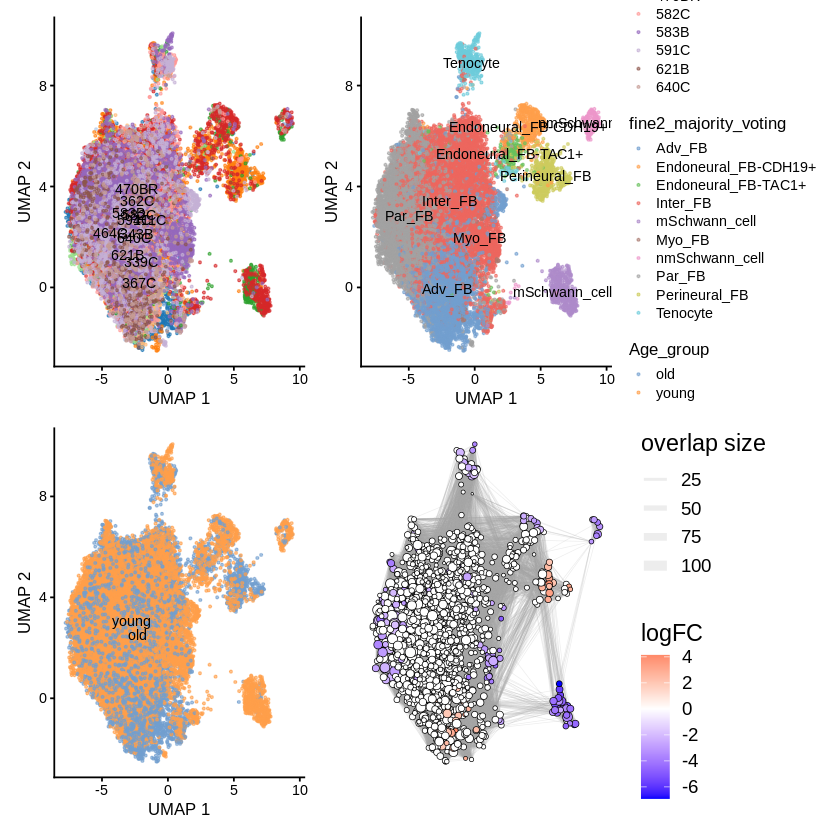

In [11]:
## Plot single-cell UMAP
umap_pl1 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="DonorID", text_by = "DonorID", text_size = 3, point_size=0.5) +  guides(fill="none")
umap_pl2 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="fine2_majority_voting", text_by = "fine2_majority_voting", text_size = 3, point_size=0.5) +  guides(fill="none")
umap_pl3 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="Age_group", text_by = "Age_group", text_size = 3, point_size=0.5) +  guides(fill="none")

# str(milo_obj)
## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(milo_obj, da_results, layout="UMAP",alpha=0.1) + scale_fill_gradient2(name = "logFC", low = "blue", high = "red") 

nh_plt_comb = umap_pl1+umap_pl2+umap_pl3 + nh_graph_pl + plot_layout(guides="collect")
nh_plt_comb

In [12]:
ggsave(filename = "./figure/human_SKM_v2_FB_moli_v3_r_1.png", plot = nh_plt_comb, width = 10, height = 10)

In [13]:
da_results <- annotateNhoods(milo_obj, da_results, coldata_col = "fine2_majority_voting")
head(da_results)

Converting fine2_majority_voting to factor...



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-0.2168505,10.511701,0.09450537,0.7585280039,0.907886542,1,0.902857439,Inter_FB,0.9664430
2,0.8891871,9.803869,1.04240270,0.3072718604,0.616717814,2,0.600263664,Inter_FB,0.8108108
3,0.6089433,10.334273,0.76747145,0.3810076911,0.683806923,3,0.668683658,Par_FB,0.5066667
4,-3.9031910,10.226015,18.12523069,0.0000207505,0.001765867,4,0.001105662,Par_FB,0.7403846
5,2.2584106,9.335924,5.79110577,0.0161136818,0.124661302,5,0.109724421,Inter_FB,0.8135593
6,0.5328402,10.346587,0.47078901,0.4926299095,0.761379006,6,0.749625163,Adv_FB,0.9919355


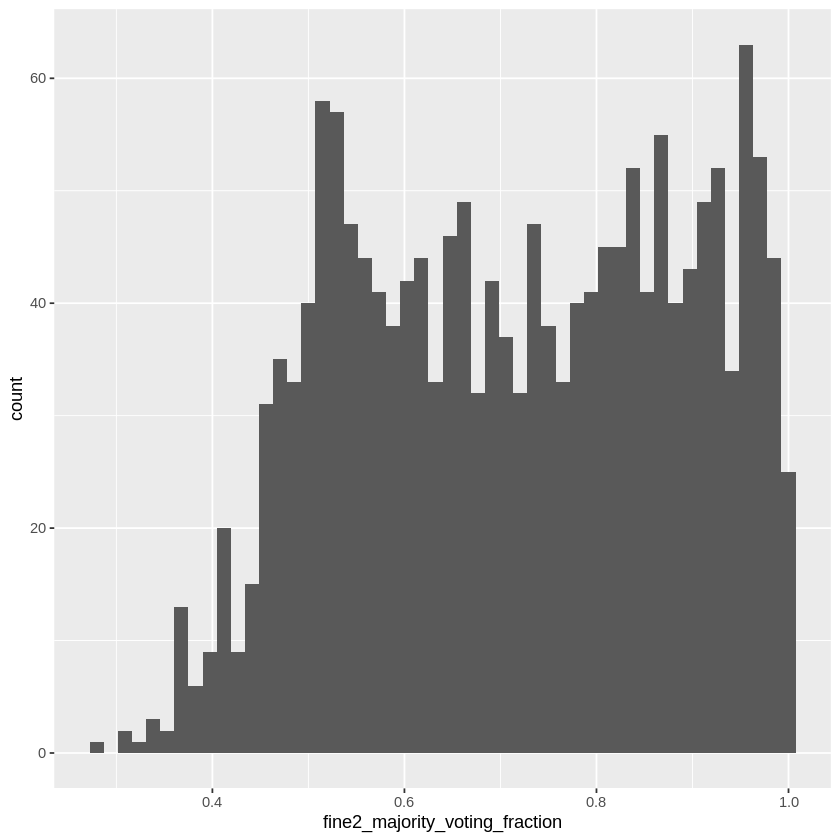

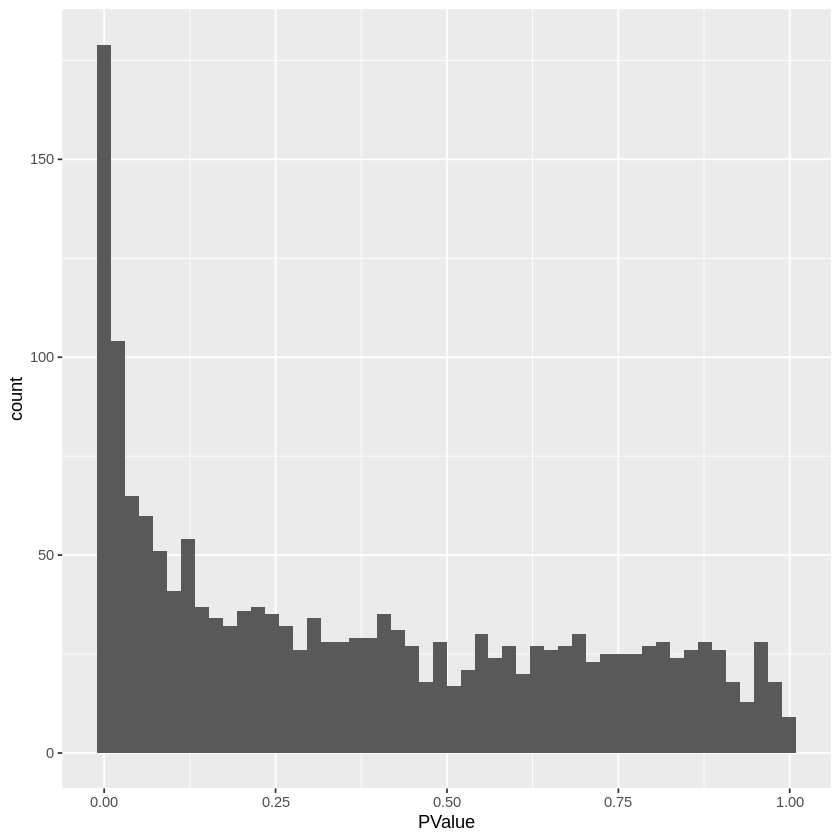

In [14]:
ggplot(da_results, aes(fine2_majority_voting_fraction)) + geom_histogram(bins=50)
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

In [15]:
da_results$fine2_majority_voting_clean <- ifelse(da_results$fine2_majority_voting_fraction < 0.7, "Mixed", da_results$fine2_majority_voting)

In [16]:
table(da_results$fine2_majority_voting_clean)


              Adv_FB Endoneural_FB-CDH19+  Endoneural_FB-TAC1+ 
                 139                   26                   12 
            Inter_FB                Mixed        mSchwann_cell 
                 383                  795                   25 
      nmSchwann_cell               Par_FB        Perineural_FB 
                   7                  259                   31 
            Tenocyte 
                  25 

In [18]:
cell_type = c('Adv_FB','Inter_FB','Par_FB','Tenocyte','Perineural_FB','Endoneural_FB-CDH19+','Endoneural_FB-TAC1+','mSchwann_cell','nmSchwann_cell')

In [19]:
da_results$fine2_majority_voting_clean <- factor(da_results$fine2_majority_voting_clean, levels=cell_type, ordered=TRUE)

In [20]:
library(ggbeeswarm)

In [21]:
da_results_clean1 = da_results[da_results$fine2_majority_voting_clean %in% cell_type,]
# da_results_clean2 = da_results[da_results$fine2_majority_voting_clean %in% c("Artery",'Arteriole-CCL2+',"Arteriole","Cap","Cap-CCL2+","Cap-Ven","Vein","Vein-CCL2+","Lymphatic","SMC","SMC-RAMP1+","SMC-CCL2+","SMC-PC","Pericyte","Pericyte-CCL2+","Pericyte-CCL26+"),]

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



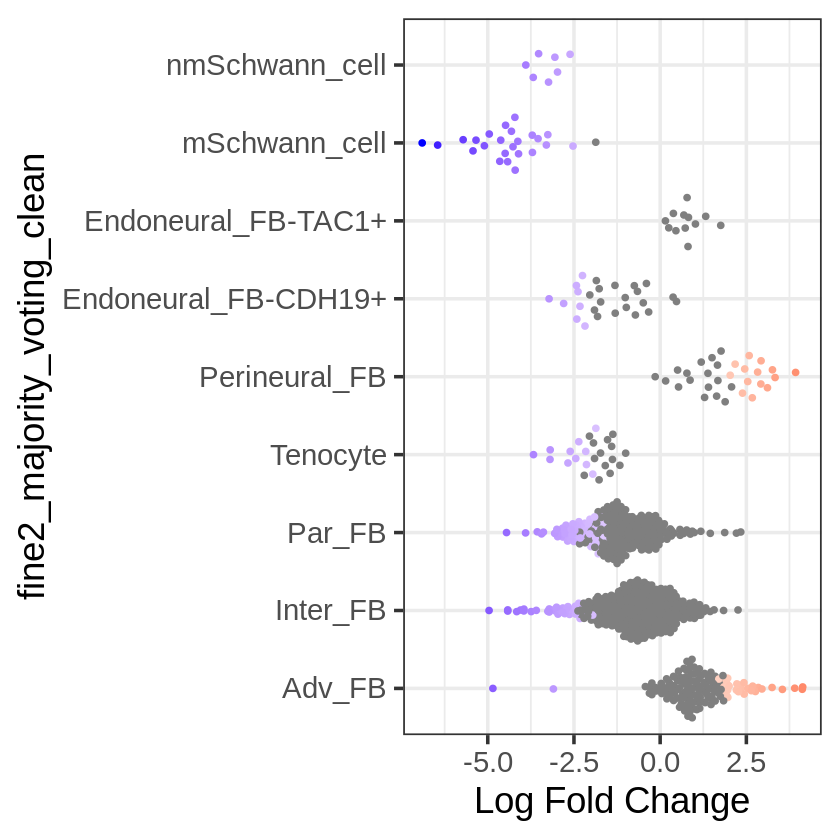

In [22]:
difab_plot = plotDAbeeswarm(da_results_clean1, group.by ="fine2_majority_voting_clean") +scale_color_gradient2(low = ("blue"), high = ("red"))
difab_plot
# difab_plot_rm = plotDAbeeswarm(da_results, subset.nhoods = !(da_results$fine2_majority_voting_clean %in% c("Vein-Lymph-CD8A+","mural-CXCL1+", 'Mixed')), group.by ="fine2_majority_voting_clean") +scale_color_gradient2(low = ("blue"), high = ("red")) 
# difab_plot_rm

Code to remove Donor specific neughbourhoods

In [17]:
da_results2 <- annotateNhoods(milo_obj, da_results, coldata_col = "DonorID")
head(da_results2)

Converting DonorID to factor...



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,-0.2168505,10.511701,0.09450537,0.7585280039,0.907886542,1,0.902857439,Inter_FB,0.9664430,Inter_FB,362C,0.3489933
2,0.8891871,9.803869,1.04240270,0.3072718604,0.616717814,2,0.600263664,Inter_FB,0.8108108,Inter_FB,362C,0.3513514
3,0.6089433,10.334273,0.76747145,0.3810076911,0.683806923,3,0.668683658,Par_FB,0.5066667,Mixed,362C,0.5200000
4,-3.9031910,10.226015,18.12523069,0.0000207505,0.001765867,4,0.001105662,Par_FB,0.7403846,Par_FB,470BR,0.5961538
5,2.2584106,9.335924,5.79110577,0.0161136818,0.124661302,5,0.109724421,Inter_FB,0.8135593,Inter_FB,362C,0.7966102
6,0.5328402,10.346587,0.47078901,0.4926299095,0.761379006,6,0.749625163,Adv_FB,0.9919355,Adv_FB,339C,0.4516129


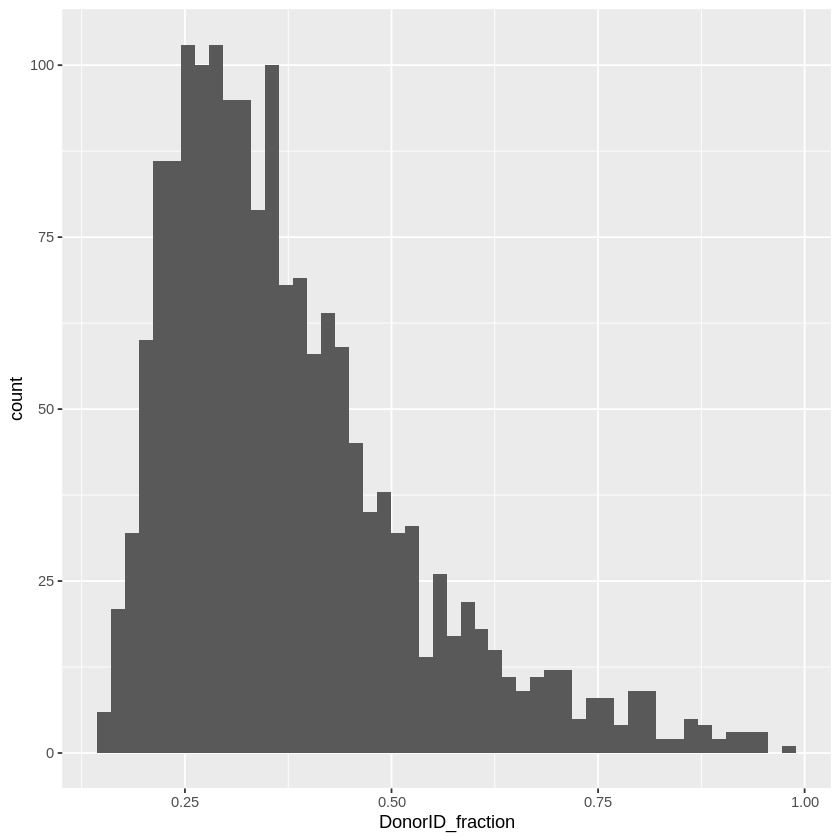

In [23]:
ggplot(da_results2, aes(DonorID_fraction)) + geom_histogram(bins=50)

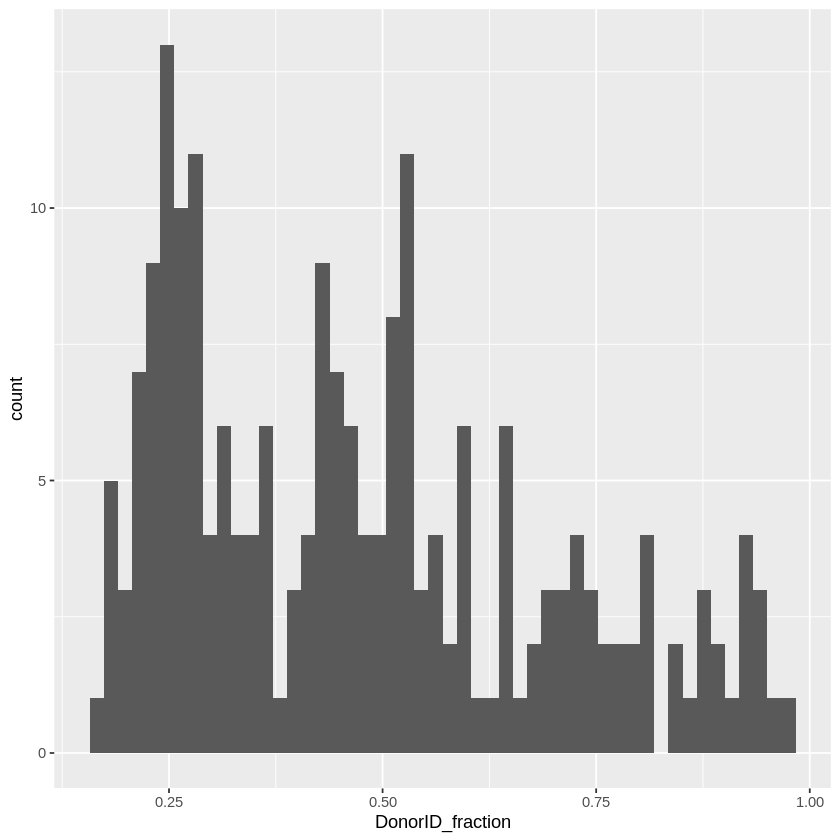

In [24]:
ggplot(da_results2[da_results2$SpatialFDR<0.1,], aes(DonorID_fraction)) + geom_histogram(bins=50)

In [25]:
head(da_results2)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,-0.2168505,10.511701,0.09450537,0.7585280039,0.907886542,1,0.902857439,Inter_FB,0.9664430,Inter_FB,362C,0.3489933
2,0.8891871,9.803869,1.04240270,0.3072718604,0.616717814,2,0.600263664,Inter_FB,0.8108108,Inter_FB,362C,0.3513514
3,0.6089433,10.334273,0.76747145,0.3810076911,0.683806923,3,0.668683658,Par_FB,0.5066667,Mixed,362C,0.5200000
4,-3.9031910,10.226015,18.12523069,0.0000207505,0.001765867,4,0.001105662,Par_FB,0.7403846,Par_FB,470BR,0.5961538
5,2.2584106,9.335924,5.79110577,0.0161136818,0.124661302,5,0.109724421,Inter_FB,0.8135593,Inter_FB,362C,0.7966102
6,0.5328402,10.346587,0.47078901,0.4926299095,0.761379006,6,0.749625163,Adv_FB,0.9919355,Adv_FB,339C,0.4516129


In [26]:
da_results2$annotation_level1_clean = da_results2$fine2_majority_voting_clean

In [27]:
da_results2$annotation_level1_clean2 <- ifelse(da_results2$DonorID_fraction > 0.9, "Donor-specific", da_results2$annotation_level1_clean)

In [28]:
head(da_results2)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction,annotation_level1_clean,annotation_level1_clean2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,-0.2168505,10.511701,0.09450537,0.7585280039,0.907886542,1,0.902857439,Inter_FB,0.9664430,Inter_FB,362C,0.3489933,Inter_FB,Inter_FB
2,0.8891871,9.803869,1.04240270,0.3072718604,0.616717814,2,0.600263664,Inter_FB,0.8108108,Inter_FB,362C,0.3513514,Inter_FB,Inter_FB
3,0.6089433,10.334273,0.76747145,0.3810076911,0.683806923,3,0.668683658,Par_FB,0.5066667,Mixed,362C,0.5200000,Mixed,Mixed
4,-3.9031910,10.226015,18.12523069,0.0000207505,0.001765867,4,0.001105662,Par_FB,0.7403846,Par_FB,470BR,0.5961538,Par_FB,Par_FB
5,2.2584106,9.335924,5.79110577,0.0161136818,0.124661302,5,0.109724421,Inter_FB,0.8135593,Inter_FB,362C,0.7966102,Inter_FB,Inter_FB
6,0.5328402,10.346587,0.47078901,0.4926299095,0.761379006,6,0.749625163,Adv_FB,0.9919355,Adv_FB,339C,0.4516129,Adv_FB,Adv_FB


In [29]:
table(da_results2$annotation_level1_clean2)


              Adv_FB       Donor-specific Endoneural_FB-CDH19+ 
                 139                   10                   26 
 Endoneural_FB-TAC1+             Inter_FB                Mixed 
                  12                  383                  795 
       mSchwann_cell       nmSchwann_cell               Par_FB 
                  24                    7                  259 
       Perineural_FB             Tenocyte 
                  22                   25 

In [30]:
da_results2$annotation_level1_clean2 = factor(da_results2$annotation_level1_clean2, levels = 
                                             c(cell_type,'Mixed' ,"Donor-specific"))

In [31]:
figures_path = './figure/'
tables_path = './table/'

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



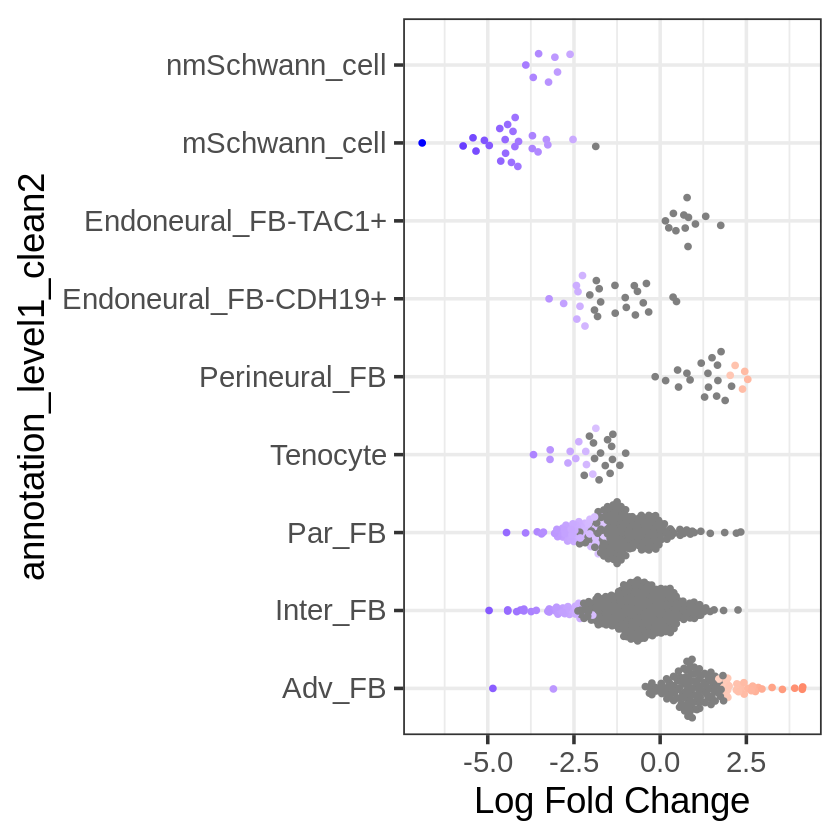

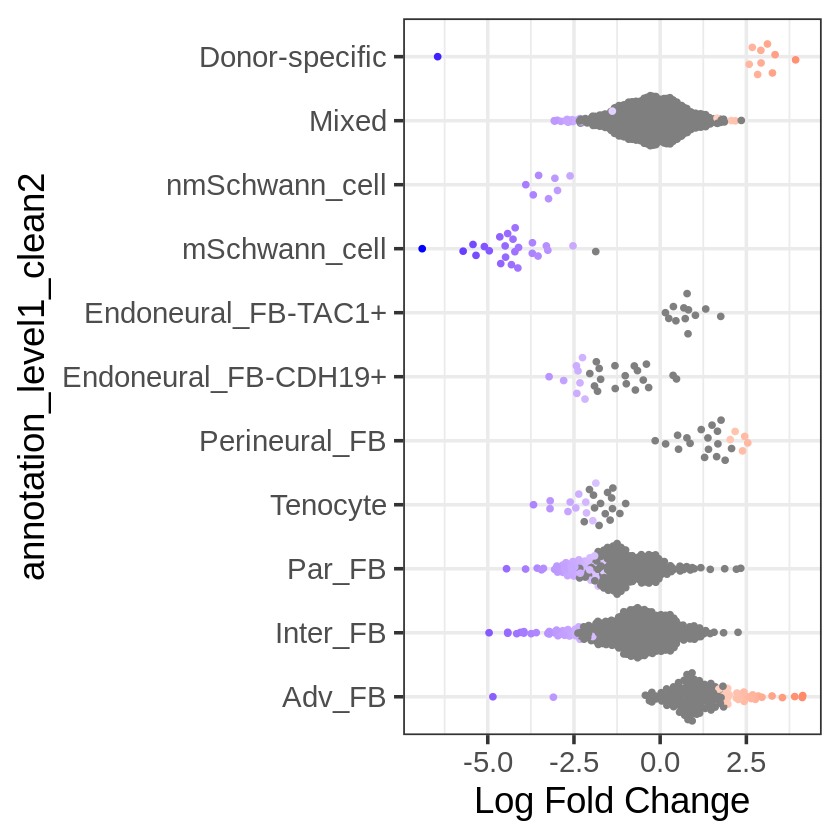

In [32]:
difab_plot_rm = plotDAbeeswarm(da_results2, subset.nhoods = !(da_results2$annotation_level1_clean2 %in% c( 'Donor-specific','Mixed')), 
                            group.by ="annotation_level1_clean2") +scale_color_gradient2(low = ("blue"), high = ("red"))
difab_plot_rm
ggsave(filename = paste0(figures_path, "human_SKM_v2_FB_moli_v3_r_Donorfilt.pdf"), plot = difab_plot_rm, width = 6, height = 5)

difab_plot_all = plotDAbeeswarm(da_results2, group.by ="annotation_level1_clean2") +scale_color_gradient2(low = ("blue"), high = ("red")) 
difab_plot_all
ggsave(filename = paste0(figures_path, "human_SKM_v2_FB_moli_v3_r_all.pdf"), plot = difab_plot_all, width = 6, height = 5)

Change LogFC to 0 for Donor-specific and Mixed neighbourhoods (won't be displayed on umap)

In [33]:
da_results2$logFC2 = ifelse(da_results2$annotation_level1_clean2 %in% c('Mixed', 'Donor-specific'), 0, da_results2$logFC)

In [34]:
milo_obj = buildNhoodGraph(milo_obj)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



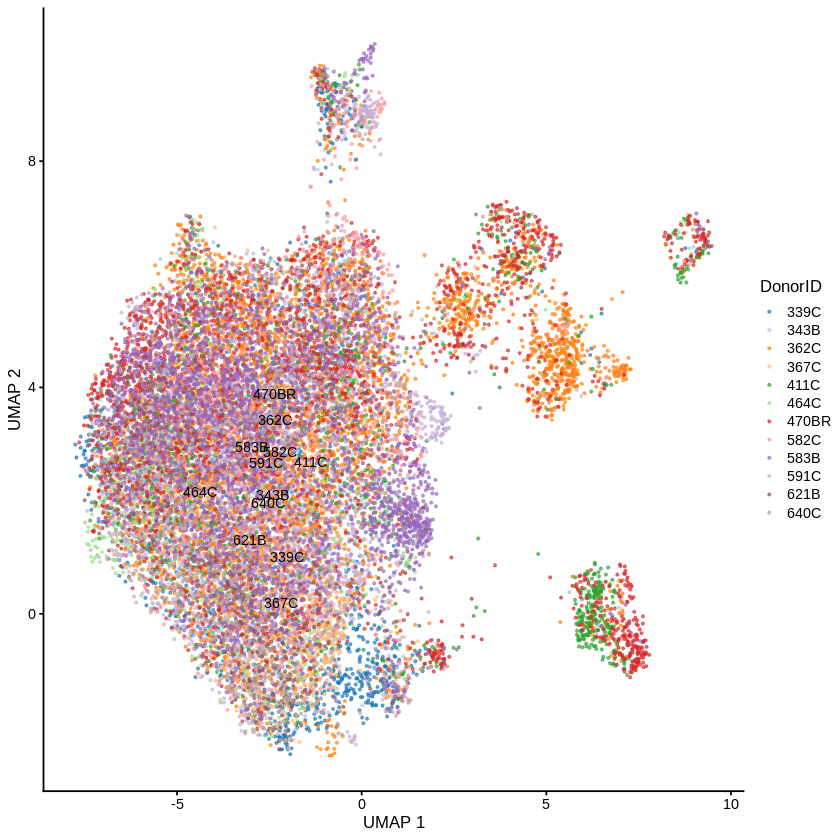

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



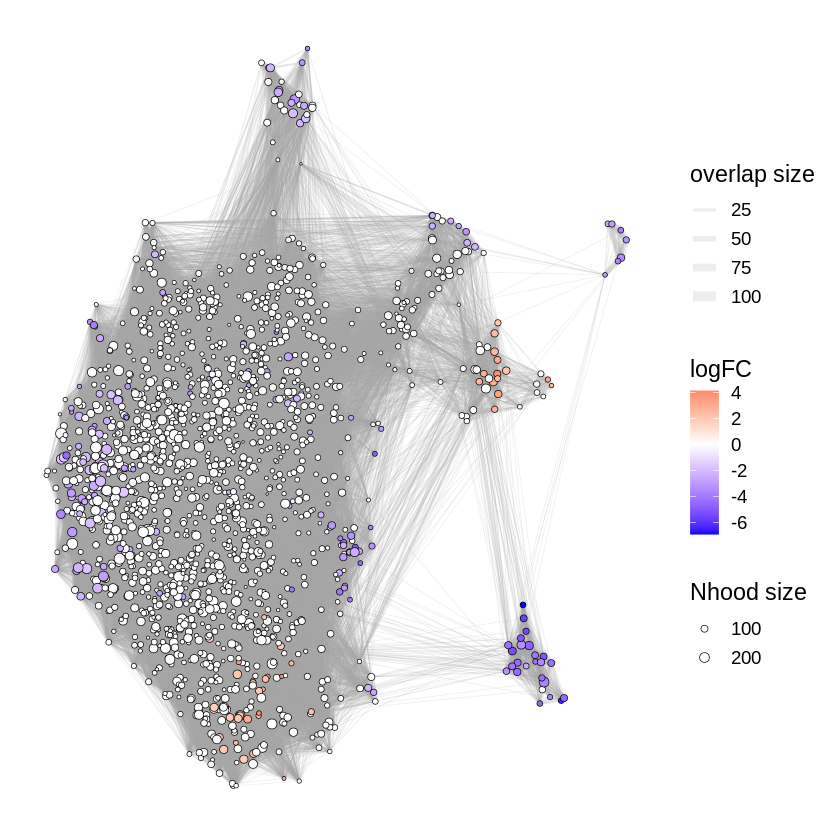

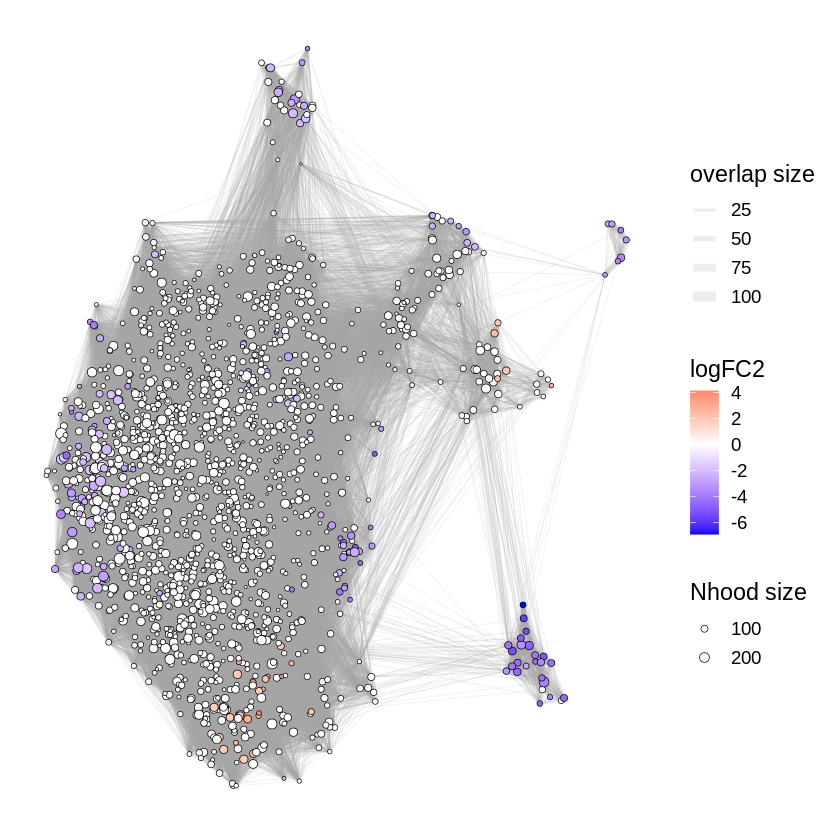

In [35]:
umap_pl <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="DonorID", 
                           text_by = "DonorID",text_size = 3, point_size=0.5) +
  guides(fill="none")
umap_pl

ggsave(paste0(figures_path, "human_SKM_v2_FB_moli_v3_rdonor.pdf"), umap_pl, width = 4, height = 3.5)
## plot neighbourhood graph highlighting nhds with significant chnages 
## (Donor-specific and mixed populations are kept in)
nh_graph_pl1 <- plotNhoodGraphDA(milo_obj, da_results2, layout="UMAP",alpha=0.1) + 
scale_fill_gradient2(name = "logFC", low = ("blue"), high = ("red")) 
nh_graph_pl1
ggsave(paste0(figures_path, "human_SKM_v2_FB_moli_v3_r_nhds.pdf"), nh_graph_pl1, width = 4, height = 3.5)
ggsave(paste0(figures_path, "human_SKM_v2_FB_moli_v3_r_nhds.png"), nh_graph_pl1, width = 4, height = 3.5)
## plot neighbourhood graph highlighting nhds with significant chnages 
## (Donor-specific and mixed populations are removed)
nh_graph_pl2 <- plotNhoodGraphDA(milo_obj, da_results2, layout="UMAP",alpha=0.1, res_column = "logFC2") + 
scale_fill_gradient2(name = "logFC2", low = ("blue"), high = ("red"))

nh_graph_pl2
ggsave(paste0(figures_path, "human_SKM_v2_FB_moli_v3_r_nhds_filt.pdf"), nh_graph_pl2, width = 4, height = 3.5)
ggsave(paste0(figures_path, "human_SKM_v2_FB_moli_v3_r_nhds_filt.png"), nh_graph_pl2, width = 4, height = 3.5)
#nh_plt_comb = umap_pl + nh_graph_pl1 +nh_graph_pl2
#  plot_layout(guides="collect")

In [36]:
fwrite(da_results2, file = paste0(tables_path,"human_SKM_v2_FB_moli_v3_r_all.csv"))